<a href="https://colab.research.google.com/github/StachysAE/SmartPlate-Food-Classification/blob/main/SmartPlate-Food-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import os
import cv2
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from collections import Counter

# Define dataset paths
dataset_dir = "/content/drive/MyDrive/south_indian_dataset"
train_csv = os.path.join(dataset_dir, "train", "_annotations.csv")
train_img_dir = os.path.join(dataset_dir, "train")

# Read the CSV file
df = pd.read_csv(train_csv)

# Extract unique classes and create a mapping
class_names = df["class"].unique().tolist()
class_to_idx = {cls: i for i, cls in enumerate(class_names)}
num_classes = len(class_names)

# Function to load image and preprocess labels
def load_image_and_label(row):
    img_path = os.path.join(train_img_dir, row["filename"])

    if not os.path.exists(img_path):
        print(f"File missing")
        return None

    img = cv2.imread(img_path)

    if img is None:
        print(f"Skipping unreadable file")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA) / 255.0  # Normalize

    label = class_to_idx[row["class"]]
    return img, label

# Generator function to load data dynamically
def data_generator():
    for _, row in df.iterrows():
        data = load_image_and_label(row)
        if data is not None:
            yield data  # Returns (image, label) one by one

# Convert generator into a TensorFlow Dataset
train_ds = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).shuffle(5000).batch(32).repeat().prefetch(tf.data.AUTOTUNE)  # Prevents running out of data

# Compute class weights (optional, helps if classes are imbalanced)
class_counts = Counter(df["class"])
total_samples = sum(class_counts.values())
class_weights = {class_to_idx[label]: total_samples / count for label, count in class_counts.items()}

# Build the classification model using MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pretrained weights

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")  # Multi-class classification
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Train model (steps_per_epoch ensures dataset doesn't run out)
steps_per_epoch = len(df) // 32
history = model.fit(train_ds, epochs=20, steps_per_epoch=steps_per_epoch, class_weight=class_weights)

# Save the trained model
model.save("south_indian_model1.h5")

print("✅ Training complete! Model saved as 'south_indian_model1.h5'")


Epoch 1/20
File missing
File missing
269/269 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.2667 - loss: 82.0820
Epoch 2/20
  1/269 ━━━━━━━━━━━━━━━━━━━━ 3:18 740ms/step - accuracy: 0.5385 - loss: 51.1913File missing
File missing
269/269 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.5786 - loss: 42.0903
Epoch 3/20
  2/269 ━━━━━━━━━━━━━━━━━━━━ 1:56 437ms/step - accuracy: 0.4833 - loss: 44.0980File missing
File missing
269/269 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.6230 - loss: 35.3068
Epoch 4/20
  3/269 ━━━━━━━━━━━━━━━━━━━━ 5:41 1s/step - accuracy: 0.7355 - loss: 28.1723File missing
File missing
269/269 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.6761 - loss: 30.1052
Epoch 5/20
  4/269 ━━━━━━━━━━━━━━━━━━━━ 6:31 1s/step - accuracy: 0.6091 - loss: 31.6955File missing
File missing
269/269 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.6931 - loss: 27.3862
Epoch 6/20
  5/269 ━━━━━━━━━━━━━━━━━━━━ 6:27 1s/step - accuracy: 0.7023 - loss: 27.9366File missing
File missing
227/269

✅ Training complete! Model saved as 'south_indian_model1.h5'


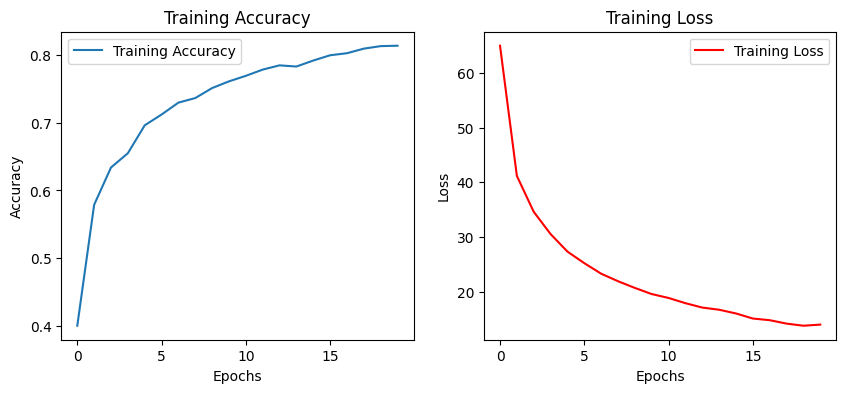

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from history
acc = history.history['accuracy']
loss = history.history['loss']

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training Loss")

plt.show()


In [ ]:
# Define test dataset paths
test_csv = os.path.join(dataset_dir, "test", "_annotations.csv")
test_img_dir = os.path.join(dataset_dir, "test")

# Read the test CSV file
df_test = pd.read_csv(test_csv)

# Function to load test images and labels (same as train)
def load_test_image_and_label(row):
    img_path = os.path.join(test_img_dir, row["filename"])

    if not os.path.exists(img_path):
        print(f" ⚠️ File missing: {img_path}")
        return None

    img = cv2.imread(img_path)

    if img is None:
        print(f" ⚠️ Skipping unreadable file: {img_path}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA) / 255.0  # Normalize

    label = class_to_idx[row["class"]]
    return img, label

# Generator function for test dataset
def test_data_generator():
    for _, row in df_test.iterrows():
        data = load_test_image_and_label(row)
        if data is not None:
            yield data  # Returns (image, label) one by one

# Convert test generator into TensorFlow Dataset
test_ds = tf.data.Dataset.from_generator(
    test_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(32).prefetch(tf.data.AUTOTUNE)  # Batch and prefetch to improve performance

# Now, test your model
test_loss, test_acc = model.evaluate(test_ds)
print(f"🟢 Test Accuracy: {test_acc * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 272s 13s/step - accuracy: 0.7920 - loss: 0.7335
🟢 Test Accuracy: 78.81%


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━

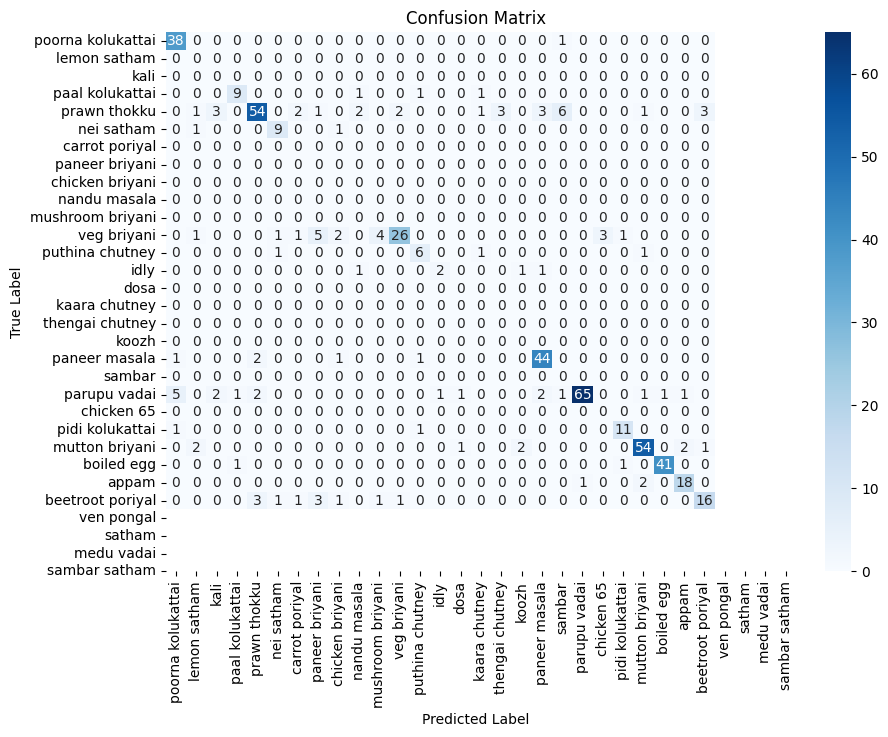

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Load test images and labels
y_true, y_pred = [], []

for img, label in test_ds.unbatch().take(500):  # Limit for efficiency
    y_true.append(label.numpy())
    pred = model.predict(tf.expand_dims(img, axis=0))
    y_pred.append(np.argmax(pred))

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Path to the image you want to test
image_path = "/content/drive/MyDrive/Indian Food Images/rice/download.jpg"

# Preprocess the image
input_image = preprocess_image(image_path)

if input_image is not None:
    # Predict the class
    predictions = model.predict(input_image)

    # Get the class index with highest probability
    predicted_class_index = np.argmax(predictions)

    # Get the class name
    predicted_class_name = class_names[predicted_class_index]

    print(f"🟢 Predicted Class: {predicted_class_name} (Index: {predicted_class_index})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
🟢 Predicted Class: satham (Index: 28)
